In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [2]:
data_dir='Brain Tumor Data Set'
os.listdir(data_dir)

['test data', 'train data']

In [3]:
test_path = data_dir+'\\test data\\'
train_path = data_dir+'\\train data\\'

In [4]:
os.listdir(train_path)

['healthy', 'tumor']

In [5]:
os.listdir(test_path)

['healthy', 'tumor']

In [6]:
os.listdir(train_path+'healthy')[20]

'Not Cancer  (1057).jpg'

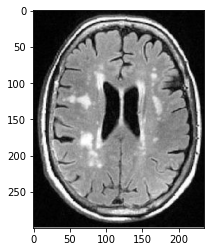

In [7]:
no_cancer=train_path+'healthy\\'+'Not Cancer  (1057).jpg'
plt.imshow(imread(no_cancer))

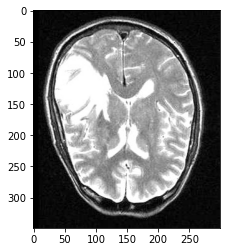

In [8]:
cancerous = train_path+'\\tumor\\'+os.listdir(train_path+'\\tumor')[23]
cancerous= imread(cancerous)
plt.imshow(cancerous)

In [9]:
len(os.listdir(train_path+'\\healthy'))

1044

In [10]:
len(os.listdir(train_path+'\\tumor'))

1257

In [11]:
cancerous.shape

(349, 300, 3)

In [12]:
image_shape = (130,130,3)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
#help(ImageDataGenerator)
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [15]:

image_gen.flow_from_directory(train_path)

Found 2301 images belonging to 2 classes.


In [16]:
image_gen.flow_from_directory(test_path)

Found 2299 images belonging to 2 classes.


# CREATING OUR MODEL

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [18]:

#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [21]:
batch_size = 16

In [22]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 2301 images belonging to 2 classes.


In [23]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2299 images belonging to 2 classes.


In [24]:

train_image_gen.class_indices

{'healthy': 0, 'tumor': 1}

In [25]:
%%time
results = model.fit_generator(train_image_gen,epochs=10,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/10
144/144 [==============================] - 77s 528ms/step - loss: 0.6268 - accuracy: 0.6639 - val_loss: 0.7667 - val_accuracy: 0.4315
Epoch 2/10
144/144 [==============================] - 52s 359ms/step - loss: 0.5203 - accuracy: 0.7328 - val_loss: 0.9382 - val_accuracy: 0.4337
Epoch 3/10
144/144 [==============================] - 52s 361ms/step - loss: 0.4422 - accuracy: 0.7949 - val_loss: 1.0166 - val_accuracy: 0.4476
Wall time: 3min


In [26]:
from tensorflow.keras.models import load_model
model.save('cancer_model.H5')

INFO:tensorflow:Assets written to: cancer_model.H5\assets


In [27]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

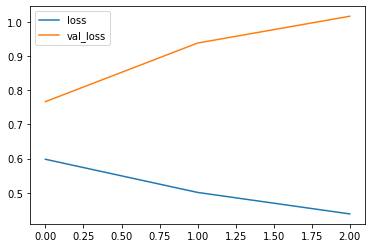

In [28]:
losses[['loss','val_loss']].plot()

In [29]:
model.evaluate_generator(test_image_gen)

[1.018247127532959, 0.45585036277770996]

In [30]:

from tensorflow.keras.preprocessing import image

In [31]:
pred_probabilities = model.predict_generator(test_image_gen)

In [32]:
pred_probabilities

array([[1.4387023e-01],
       [8.2733411e-01],
       [3.3015232e-07],
       ...,
       [6.2454891e-01],
       [2.7042779e-01],
       [8.4921581e-01]], dtype=float32)

In [33]:
predictions = pred_probabilities > 0.5

In [34]:

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.43      0.65      0.52      1043
           1       0.50      0.29      0.37      1256

    accuracy                           0.45      2299
   macro avg       0.46      0.47      0.44      2299
weighted avg       0.47      0.45      0.43      2299



In [35]:
confusion_matrix(test_image_gen.classes,predictions)

array([[674, 369],
       [891, 365]], dtype=int64)

In [36]:
no_cancer

'Brain Tumor Data Set\\train data\\healthy\\Not Cancer  (1057).jpg'

In [37]:
my_image = image.load_img(no_cancer,target_size=image_shape)

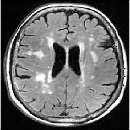

In [38]:
my_image

In [39]:
my_image = image.img_to_array(my_image)

In [40]:

my_image.shape

(130, 130, 3)

In [41]:
my_image = np.expand_dims(my_image, axis=0)

In [42]:
my_image.shape

(1, 130, 130, 3)

In [43]:
model.predict(my_image)

array([[1.]], dtype=float32)

In [44]:
train_image_gen.class_indices

{'healthy': 0, 'tumor': 1}

In [45]:

test_image_gen.class_indices

{'healthy': 0, 'tumor': 1}